In [1]:
################################################################################################
#                                   最优订货量决策例子
#                                    （2020-09-27）
################################################################################################

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import math
import itertools

from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
#===============================================================================================#
### 1. 成本计算函数、EOQ成本计算 ###
#===============================================================================================#

#-----------------------------------------------------------------------------------------------#
# inventory_cost_df：给定订货策略 Q_list，成本结果函数
#-----------------------------------------------------------------------------------------------#
def inventory_cost_df(days, P_list, D_list, Q_list, fast=False):
    
    ### params ###
    # 单位订货固定成本（shipment cost）：
    S = 240
    # 单位产品日均存货成本：
    C = 3
    # 单位产品日均缺货成本：
    IC = 10

    # 准备空列表
    day_i_list = [i for i in range(days)] # 总天数
    Stock_list = [None for i in range(days)]
    Ins_list = [None for i in range(days)]
    Cost_pq_list = [None for i in range(days)]
    Cost_ship_list = [None for i in range(days)]
    Cost_stock_list = [None for i in range(days)]
    Cost_ins_list = [None for i in range(days)]
    Cost_list = [None for i in range(days)]
    
    ### 按日处理 ###
    for day_i in range(days):
        
        # 昨日库存：
        if day_i == 0:
            l_stock = 0
        else:
            l_stock = Stock_list[day_i-1]
        # 今日价格：
        p = P_list[day_i]
        # 今日订货量：
        q = Q_list[day_i]
        # 今日需求量：
        d = D_list[day_i]
        # 更新今日库存 = 昨日库存 + 今日购进 - 今日使用量
        stock = l_stock + q - d # 今日结束时的库存（负数表示缺货）
        Stock_list[day_i] = stock # 记录
        # 今日缺货量：
        if Stock_list[day_i] < 0:
            ins = abs(Stock_list[day_i]) # 缺货量（正数）
        else:
            ins = 0
        Ins_list[day_i] = ins # 记录
        
        ### 今日成本计算 ###
        # 购进产品总价值
        cost_pq = q * p 
        # 运输成本 ，如果进货（q > 0），则付出运输成本 S，否则为 0
        if q > 0:
            cost_ship = S 
        else:
            cost_ship = 0
        # 存储成本，假设日内需求均匀发生，带来半数的等效库存成本
        cost_stock = C * (max(stock, 0) + min(d, max(q + l_stock, 0))/2) 
        # 缺货成本 = IC * 缺货量（正数）
        cost_ins = IC * ins 
        # 总成本
        cost = cost_pq + cost_ship + cost_stock + cost_ins 
        
        # 修改相应 list 中该日的数值
        Cost_pq_list[day_i] = cost_pq
        Cost_ship_list[day_i] = cost_ship
        Cost_stock_list[day_i] = cost_stock
        Cost_ins_list[day_i] = cost_ins
        Cost_list[day_i] = cost
        
    ### 存入 pandas df ###
    if fast == True:
        data = Cost_list
        df = pd.DataFrame(data=data, columns=['总成本'])
        df['累计总成本'] = df['总成本'].cumsum()
    else:
        data = zip(day_i_list, P_list, D_list, Q_list, Stock_list, Ins_list, Cost_list, Cost_pq_list, Cost_ship_list, Cost_stock_list, Cost_ins_list)
        df = pd.DataFrame(data=data, columns=['日期', '价格', '需求量', '订货量', '库存量', '缺货量', '总成本', '购进货物价值', '运输成本', '库存成本', '缺货成本'])
        df['累计需求量'] = df['需求量'].cumsum()
        df['累计订货量'] = df['订货量'].cumsum()
        df['累计总成本'] = df['总成本'].cumsum()
        df['累计运输成本'] = df['运输成本'].cumsum()
        df['累计库存成本'] = df['库存成本'].cumsum()
        df['累计缺货成本'] = df['缺货成本'].cumsum()
    
    #### return ###
    return df
#-----------------------------------------------------------------------------------------------#


In [3]:
#-----------------------------------------------------------------------------------------------#
# 用刚刚的函数计算 Economic Order Quantity (EOQ) 的总成本
#-----------------------------------------------------------------------------------------------#
### params ###
# 总天数：
days = 60
day_i_list = [i for i in range(days)]
# 日均订货量（demand）：
D = 10
# 产品单位价格：
P = 20
# 单位订货固定成本（shipment cost）：
S = 240.0
# 单位产品日均存货成本：
C = 3.0
# 单位产品日均缺货成本：
IC = 10.0
    
### Q_list_EOQ ###
# 最优每次订货量（quantity）：Q = sqrt(2 * D * S / C)
Q = (2 * D * S / C) ** 0.5
print(f'EOQ公式 最优每次订货量：{Q}')
# 最优订货次数：N = D * days / Q
N = D * days / Q
print(f'EOQ公式 最优订货次数：{N}')
# 订货周期天数：T = 1 / N * days
T = 1 / N * days
print(f'EOQ公式 订货周期天数：{T}')
# 订货计划
Q_list = []
for day_i in range(days):
    # 如果到了订货周期
    if day_i % T == 0:
        Q_list.append(Q)
    else:
        Q_list.append(0)
# Q_list_EOQ
Q_list_EOQ = Q_list

# EOQ 模型各日订货量
print(f'EOQ公式 订货计划：{Q_list}')   
# EOQ 模型总固定订购成本（运输成本）：S * N = S * D * days / Q
print(f'EOQ公式 总运输成本：{S * D * days / Q}')
# EOQ 模型总库存成本（储藏/存放成本）：(Q / 2) * C * days
print(f'EOQ公式 总库存成本：{(Q / 2) * C * days}')
# EOQ 模型总成本：
print(f'EOQ公式 总成本：{S * D * days / Q + (Q / 2) * C * days}')


### 计算 EOQ 模型的成本 ###
days = 60
P_list = [P for i in range(days)]
D_list = [D for i in range(days)]
# inventory_cost_df(days, P_list, D_list, Q_list_EOQ, fast=True)
df = inventory_cost_df(days, P_list, D_list, Q_list_EOQ)
df


EOQ公式 最优每次订货量：40.0
EOQ公式 最优订货次数：15.0
EOQ公式 订货周期天数：4.0
EOQ公式 订货计划：[40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0]
EOQ公式 总运输成本：3600.0
EOQ公式 总库存成本：3600.0
EOQ公式 总成本：7200.0


,日期,价格,需求量,订货量,库存量,缺货量,总成本,购进货物价值,运输成本,库存成本,缺货成本,累计需求量,累计订货量,累计总成本,累计运输成本,累计库存成本,累计缺货成本
0,0,20,10,40.0,30.0,0,1145.0,800.0,240,105.0,0,10,40.0,1145.0,240,105.0,0
1,1,20,10,0.0,20.0,0,75.0,0.0,0,75.0,0,20,40.0,1220.0,240,180.0,0
2,2,20,10,0.0,10.0,0,45.0,0.0,0,45.0,0,30,40.0,1265.0,240,225.0,0
3,3,20,10,0.0,0.0,0,15.0,0.0,0,15.0,0,40,40.0,1280.0,240,240.0,0
4,4,20,10,40.0,30.0,0,1145.0,800.0,240,105.0,0,50,80.0,2425.0,480,345.0,0
5,5,20,10,0.0,20.0,0,75.0,0.0,0,75.0,0,60,80.0,2500.0,480,420.0,0
6,6,20,10,0.0,10.0,0,45.0,0.0,0,45.0,0,70,80.0,2545.0,480,465.0,0
7,7,20,10,0.0,0.0,0,15.0,0.0,0,15.0,0,80,80.0,2560.0,480,480.0,0
8,8,20,10,40.0,30.0,0,1145.0,800.0,240,105.0,0,90,120.0,3705.0,720,585.0,0
9,9,20,10,0.0,20.0,0,75.0,0.0,0,75.0,0,100,120.0,3780.0,720,660.0,0


In [ ]:
# ### matplotlib plot ###
# fig, ax = plt.subplots(dpi=300)
# ax.bar(df['日期'], df['库存成本'])
# ax.bar(df['日期'], df['运输成本'], bottom=df['库存成本'])
# ax.set_yticks(range(0,351,50))
# ax2 = ax.twinx()
# ax2.plot(df['日期'], (df['累计库存成本']+df['累计库存成本']), marker='.', alpha=0.5, color='green')
# # ax2.plot(best_df['日期'], best_df['累计总成本'], marker='.', alpha=0.5, color='red')
# # ax2.plot(df['日期'], df['累计缺货成本'], marker='.', alpha=0.5, color='blue')
# ax2.set_yticks(range(0,7000,1000))
# ax.set(xlabel='date', ylabel='cost', title='Costs in EOQ model')
# ax.grid()
# plt.xticks(range(0,61,4), fontproperties='Times New Roman', size=8)
# fig.savefig("C:\\Users\\weiha\\Desktop\\存货决策模型\\图1.png")
# plt.show()

In [4]:
#===============================================================================================#
### 2. 验证EOQ ###
#===============================================================================================#

#-----------------------------------------------------------------------------------------------#
# EOQ 的订购策略
Q_list_EOQ = [40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0, 40.0, 0, 0, 0]
#-----------------------------------------------------------------------------------------------#

#-----------------------------------------------------------------------------------------------#
# 我们来自己设计一个策略
#-----------------------------------------------------------------------------------------------#
### n_k_list：分 n 批，每批订购 k 个，n * k >= quantity, 可能的整数对集合 ###
### 批数不能超过天数 ###
def n_k_list(quantity, days):
    n_k_list = []
    for k in range(1, quantity + 1):
        n = math.ceil(quantity / k) # 向上取整函数
        if n > days:
            continue
        n_k_list.append((n, k))
    return n_k_list

### possible_Q_lists：给定天数、总量，等量整批订购的可选策略集合 ###
def possible_Q_lists(quantity, days):
    possible_Q_lists = []
    for n, k in n_k_list(quantity, days):
        # 间隔 days / n，订货计划
        Q_list = []
        count = 0
        for day_i in range(days):
            # 已达到总数则后续全为 0
            if sum(Q_list) >= quantity:
                Q_list.append(0)
                continue
            # 首日应当订购
            elif day_i == 0:
                Q_list.append(k)
            # 如果到了订货周期
            elif count >= days/n:
                # 订货之后超过 quantity，则减少本次 k
                if sum(Q_list) + k > quantity:
                    Q_list.append(quantity - sum(Q_list))
                else:
                    Q_list.append(k)
                count = 0
            else:
                Q_list.append(0)
            # update count
            count += 1
        # possible_Q_lists
        possible_Q_lists.append(Q_list)
    # return
    return possible_Q_lists

### our_solution1：寻找成本最低的策略 ###
def our_solution1(days, P_list, D_list):

    # lowest_record
    lowest_record = 9999999999
    quantity = sum(D_list)
    
    # all possible stategies
    for Q_list in possible_Q_lists(quantity, days):
        # total cost for Q_list.
        cost = inventory_cost_df(days, P_list, D_list, Q_list, fast=True)['累计总成本'].iloc[days-1]
        # update lowest_record
        if cost <= lowest_record:
            lowest_record = cost
            best_Q_list = Q_list
            best_df = inventory_cost_df(days, P_list, D_list, best_Q_list)
    # return
    return best_df




In [5]:
n_k_list(100, 10)

[(10, 10),
 (10, 11),
 (9, 12),
 (8, 13),
 (8, 14),
 (7, 15),
 (7, 16),
 (6, 17),
 (6, 18),
 (6, 19),
 (5, 20),
 (5, 21),
 (5, 22),
 (5, 23),
 (5, 24),
 (4, 25),
 (4, 26),
 (4, 27),
 (4, 28),
 (4, 29),
 (4, 30),
 (4, 31),
 (4, 32),
 (4, 33),
 (3, 34),
 (3, 35),
 (3, 36),
 (3, 37),
 (3, 38),
 (3, 39),
 (3, 40),
 (3, 41),
 (3, 42),
 (3, 43),
 (3, 44),
 (3, 45),
 (3, 46),
 (3, 47),
 (3, 48),
 (3, 49),
 (2, 50),
 (2, 51),
 (2, 52),
 (2, 53),
 (2, 54),
 (2, 55),
 (2, 56),
 (2, 57),
 (2, 58),
 (2, 59),
 (2, 60),
 (2, 61),
 (2, 62),
 (2, 63),
 (2, 64),
 (2, 65),
 (2, 66),
 (2, 67),
 (2, 68),
 (2, 69),
 (2, 70),
 (2, 71),
 (2, 72),
 (2, 73),
 (2, 74),
 (2, 75),
 (2, 76),
 (2, 77),
 (2, 78),
 (2, 79),
 (2, 80),
 (2, 81),
 (2, 82),
 (2, 83),
 (2, 84),
 (2, 85),
 (2, 86),
 (2, 87),
 (2, 88),
 (2, 89),
 (2, 90),
 (2, 91),
 (2, 92),
 (2, 93),
 (2, 94),
 (2, 95),
 (2, 96),
 (2, 97),
 (2, 98),
 (2, 99),
 (1, 100)]

In [6]:
possible_Q_lists(100, 10)

[[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 1],
 [12, 0, 12, 0, 12, 0, 12, 0, 12, 0],
 [13, 0, 13, 0, 13, 0, 13, 0, 13, 0],
 [14, 0, 14, 0, 14, 0, 14, 0, 14, 0],
 [15, 0, 15, 0, 15, 0, 15, 0, 15, 0],
 [16, 0, 16, 0, 16, 0, 16, 0, 16, 0],
 [17, 0, 17, 0, 17, 0, 17, 0, 17, 0],
 [18, 0, 18, 0, 18, 0, 18, 0, 18, 0],
 [19, 0, 19, 0, 19, 0, 19, 0, 19, 0],
 [20, 0, 20, 0, 20, 0, 20, 0, 20, 0],
 [21, 0, 21, 0, 21, 0, 21, 0, 16, 0],
 [22, 0, 22, 0, 22, 0, 22, 0, 12, 0],
 [23, 0, 23, 0, 23, 0, 23, 0, 8, 0],
 [24, 0, 24, 0, 24, 0, 24, 0, 4, 0],
 [25, 0, 0, 25, 0, 0, 25, 0, 0, 25],
 [26, 0, 0, 26, 0, 0, 26, 0, 0, 22],
 [27, 0, 0, 27, 0, 0, 27, 0, 0, 19],
 [28, 0, 0, 28, 0, 0, 28, 0, 0, 16],
 [29, 0, 0, 29, 0, 0, 29, 0, 0, 13],
 [30, 0, 0, 30, 0, 0, 30, 0, 0, 10],
 [31, 0, 0, 31, 0, 0, 31, 0, 0, 7],
 [32, 0, 0, 32, 0, 0, 32, 0, 0, 4],
 [33, 0, 0, 33, 0, 0, 33, 0, 0, 1],
 [34, 0, 0, 0, 34, 0, 0, 0, 32, 0],
 [35, 0, 0, 0, 35, 0, 0, 0, 30, 0],
 [36, 0, 0, 0, 36, 0,

In [7]:
###### 该策略下最优解 ######
days = 60
P = 20
P_list = [P for i in range(days)]
D = 10
D_list = [D for i in range(days)]
#
# our_Q_list = our_solution1(days, P_list, D_list)['订货量']
# for i in zip(Q_list_EOQ, our_Q_list):
#     print(f'EOQ: {i[0]}, Ours: {i[1]}')
EOQ_total_cost = inventory_cost_df(days, P_list, D_list, Q_list_EOQ)['累计总成本'].iloc[days-1]
print(f'EOQ 总成本：{EOQ_total_cost}')
Ours_total_cost = our_solution1(days, P_list, D_list)['累计总成本'].iloc[days-1]
print(f'我们的策略 总成本：{Ours_total_cost}')

# EOQ
inventory_cost_df(days, P_list, D_list, Q_list_EOQ)

# 我们的策略
our_solution1(days, P_list, D_list)

# 原因？我们的策略中 允许缺货
# 如果将缺货成本调到非常高（相当于不允许缺货），则两者一致


EOQ 总成本：19200.0
我们的策略 总成本：18906.0


,日期,价格,需求量,订货量,库存量,缺货量,总成本,购进货物价值,运输成本,库存成本,缺货成本,累计需求量,累计订货量,累计总成本,累计运输成本,累计库存成本,累计缺货成本
0,0,20,10,49,39,0,1352.0,980,240,132.0,0,10,49,1352.0,240,132.0,0
1,1,20,10,0,29,0,102.0,0,0,102.0,0,20,49,1454.0,240,234.0,0
2,2,20,10,0,19,0,72.0,0,0,72.0,0,30,49,1526.0,240,306.0,0
3,3,20,10,0,9,0,42.0,0,0,42.0,0,40,49,1568.0,240,348.0,0
4,4,20,10,0,-1,1,23.5,0,0,13.5,10,50,49,1591.5,240,361.5,10
5,5,20,10,49,38,0,1349.0,980,240,129.0,0,60,98,2940.5,480,490.5,10
6,6,20,10,0,28,0,99.0,0,0,99.0,0,70,98,3039.5,480,589.5,10
7,7,20,10,0,18,0,69.0,0,0,69.0,0,80,98,3108.5,480,658.5,10
8,8,20,10,0,8,0,39.0,0,0,39.0,0,90,98,3147.5,480,697.5,10
9,9,20,10,0,-2,2,32.0,0,0,12.0,20,100,98,3179.5,480,709.5,30



P_list = [20.0, 21.0, 19.0, 21.0, 21.0, 20.0, 19.0, 19.0, 21.0, 19.0, 20.0, 20.0, 22.0, 21.0, 20.0, 20.0, 20.0, 22.0, 20.0, 20.0, 20.0, 21.0, 20.0, 21.0, 21.0, 19.0, 19.0, 20.0, 22.0, 20.0, 20.0, 22.0, 19.0, 19.0, 20.0, 18.0, 22.0, 20.0, 19.0, 20.0, 21.0, 20.0, 20.0, 22.0, 20.0, 22.0, 18.0, 21.0, 19.0, 21.0, 22.0, 19.0, 20.0, 22.0, 21.0, 19.0, 20.0, 21.0, 21.0, 19.0]
D_list = [0, 0, 0, 0, 0, 0, 0, 2.0, 1.0, 1.0, 0, 1.0, 4.0, 0, 3.0, 1.0, 0, 0, 2.0, 2.0, 5.0, 8.0, 6.0, 11.0, 7.0, 7.0, 9.0, 10.0, 10.0, 7.0, 10.0, 12.0, 12.0, 5.0, 11.0, 12.0, 13.0, 13.0, 9.0, 10.0, 12.0, 16.0, 13.0, 19.0, 18.0, 18.0, 17.0, 20.0, 18.0, 18.0, 20.0, 21.0, 21.0, 25.0, 22.0, 23.0, 22.0, 24.0, 25.0, 26.0]


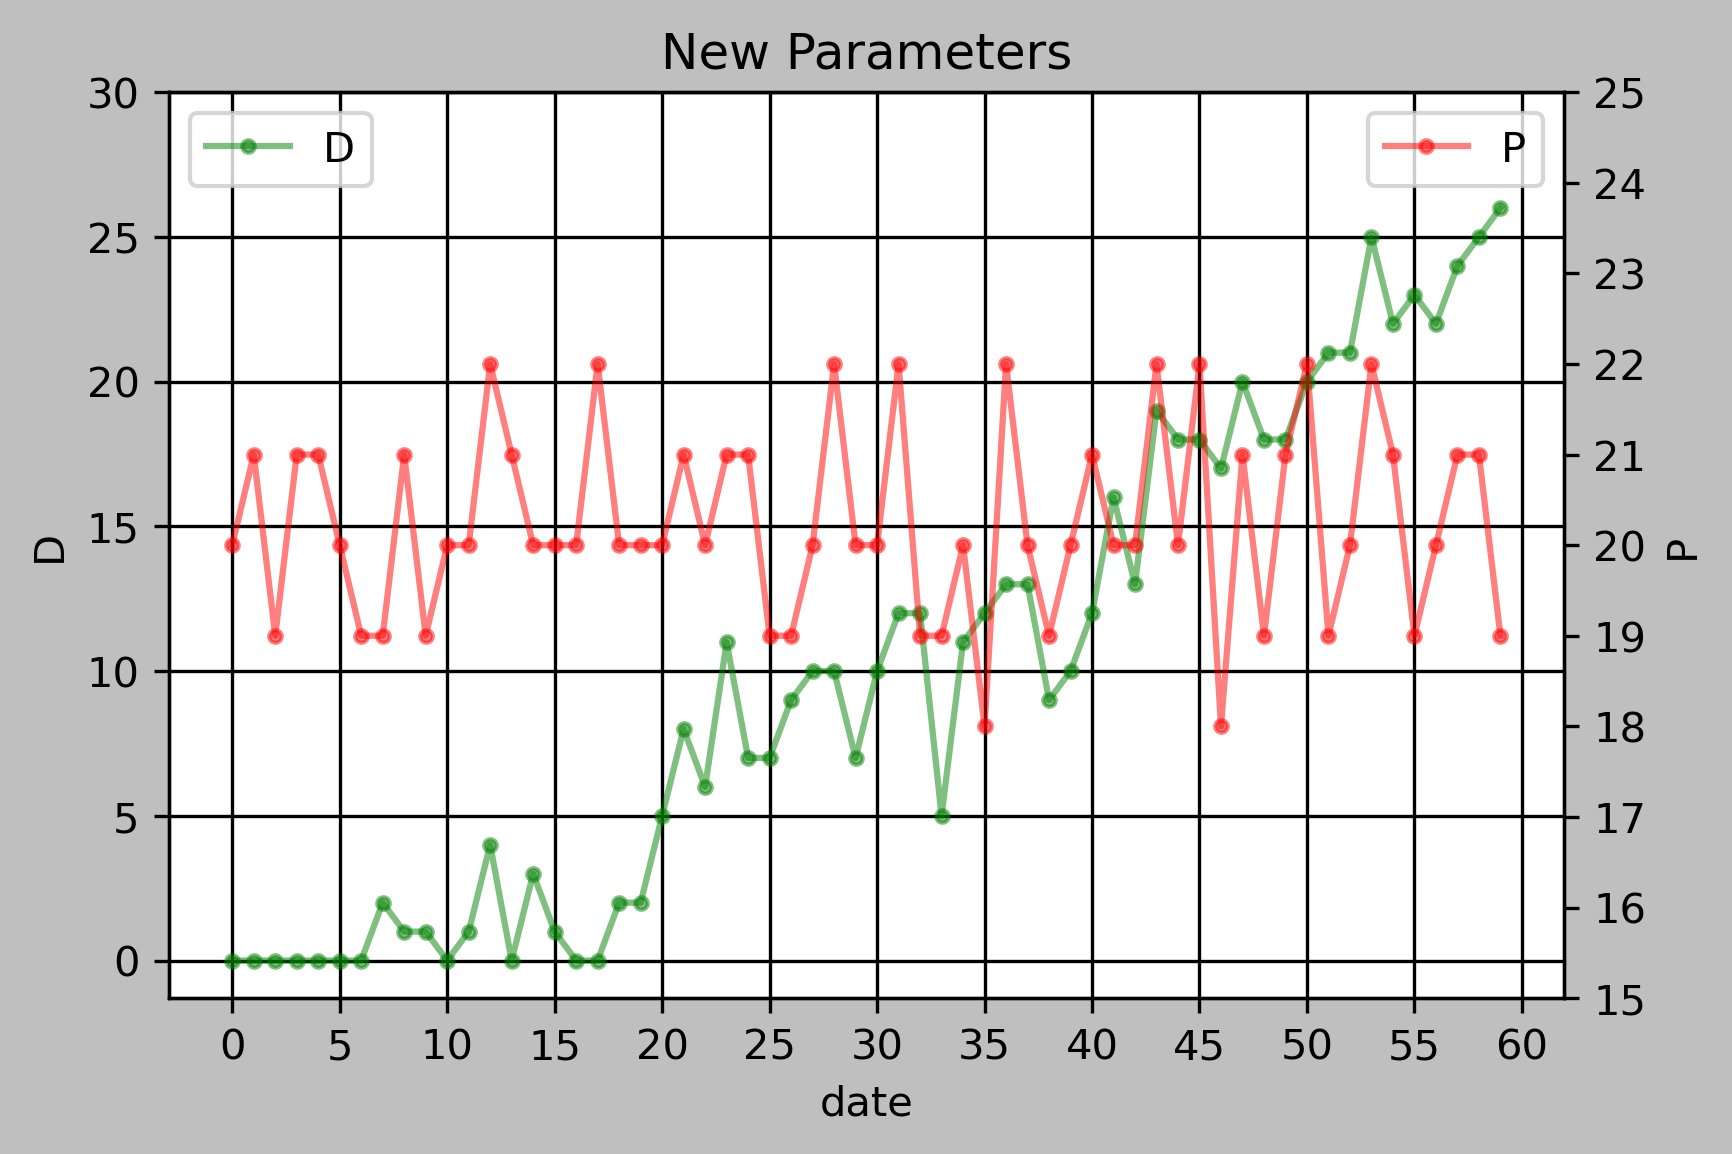

In [16]:
#===============================================================================================#
### 3. 策略2：考虑未来 P, D 均值 ###
#===============================================================================================#
#-----------------------------------------------------------------------------------------------#
# P 和 D 变量趋势
#-----------------------------------------------------------------------------------------------#
def generate_PD(days=60):
    
    ### 如果 价格 P 和 需求量 D 不再是常数 ###
    # mean(P) = 20
    P_list = [max(round(i), 1) for i in np.random.normal(20, 1, 60)]
    print(f'\nP_list = {P_list}')

    # mean(D) = 10
    D_list = [i for i in np.random.normal(10, 2, 60)]
    for i in range(len(D_list)):
        D_list[i] = round(max(D_list[i] + i/2 - 15, 0))
    print(f'D_list = {D_list}')

    ### matplotlib plot ###
    plt.style.use('grayscale')
    fig, ax = plt.subplots(dpi=300)
    #
    ax.plot([i for i in range(days)], D_list, marker='.', alpha=0.5, color='green')
    ax.set_yticks(range(0, 31, 5))
    ax.set(xlabel='date', ylabel='D', title='New Parameters')
    ax.grid()
    ax.legend(loc='upper left', frameon=True, labels=['D'])
    #
    ax2 = ax.twinx()
    ax2.plot([i for i in range(days)], P_list, marker='.', alpha=0.5, color='red')
    ax2.set_yticks(range(15, 26, 1))
    ax2.set(ylabel='P')
    ax2.legend(loc='upper right', frameon=True, labels=['P'])
    #
    plt.xticks(range(0,61,5), fontproperties='Times New Roman', size=8)
    fig.savefig("C:\\Users\\29683\\Desktop\\Study\\Computer Science\\Brother Project\\PD趋势.png")
    plt.show()
    return P_list, D_list
#-----------------------------------------------------------------------------------------------#

### 带趋势的 P 和 D ###
days = 60
P_list, D_list = generate_PD(days=days)


In [9]:
#-----------------------------------------------------------------------------------------------#
# 我们的策略2： 每天进行判断，判断时考虑接下来整批等量订购的所有 n, k 组合
#-----------------------------------------------------------------------------------------------#
### 用到 n_k_list(quantity, days) ###
# 分 n 批，每批订购 k 个，n * k >= quantity, 可能的整数对集合

### 用到 possible_Q_lists(quantity, days) ###
# 上述 n, k 对应的 Q_list

###### 假定可以正确估计剩余天数中 P 和 D 的均值 ######
def our_solution2(days, P_list, D_list):
    
    # 随着已知的 P 和 D 分布变化，更新判断和策略
    Q_list_selected = [0 for i in range(days)]
    Stock_list = [None for i in range(days)]

    # 逐日处理
    for day_i in range(days):

        # reset record
        lowest_record = 9999999999
#         print(f'\nnow: day {day_i}')

        # 剩余天数（含今日）
        days_left = days - day_i

        # 对未来 P 的均值的预测
        if day_i == days - 1:
            expected_P = None
        else:
            cum_P_today = sum(P_list[0:day_i+1])
            expected_P = (20 * days - cum_P_today) / (days_left - 1)
            expected_P = max(expected_P, 0)
#         print(f'expected_P = {expected_P}')

        # 对未来 D 的均值的预测
        if day_i == 0:
            expected_D = 10
        else:
            cum_D_yesterday = sum(D_list[0:day_i])
            expected_D = (10 * days - cum_D_yesterday) / days_left
        expected_D = max(expected_D, 0)
#         print(f'expected_D = {expected_D}')

        # 剩余天数的 P_list
        P_list_left = [expected_P for i in range(0, days_left)]
        P_list_left[0] = P_list[day_i] # 决策前已知今日价格

        # 剩余天数的 D_list
        D_list_left = [expected_D for i in range(0, days_left)]
        if Stock_list[day_i] != None:
            D_list_left[0] = expected_D - Stock_list[day_i] # 考虑昨日库存

        # 根据前日结束时仍有库存量，则不进货
        if day_i > 0 and Stock_list[day_i-1] > 0:
            best_Q = 0
        # 如需进货，则目标为：使本日及以后的总成本最低
        else:
            for Q_list in possible_Q_lists(round(expected_D * days_left), days_left):
                cost = inventory_cost_df(days_left, P_list_left, D_list_left, Q_list, fast=True)['累计总成本'].iloc[days_left-1]
                if cost <= lowest_record:
                    lowest_record = cost
                    best_Q = Q_list[0]

        # 确定本日 Q
        Q_list_selected[day_i] = best_Q

        # 更新历史库存信息
        if day_i == 0:
            Stock_list[day_i] = Q_list_selected[0] - D_list[day_i]
        else:
            Stock_list[day_i] = Stock_list[day_i-1] + Q_list_selected[day_i] - D_list[day_i]

    # cost of Q_list_selected
    best_df = inventory_cost_df(days, P_list, D_list, Q_list_selected)         
    return best_df
#-----------------------------------------------------------------------------------------------#

In [10]:
our_solution2(days, P_list, D_list)

,日期,价格,需求量,订货量,库存量,缺货量,总成本,购进货物价值,运输成本,库存成本,缺货成本,累计需求量,累计订货量,累计总成本,累计运输成本,累计库存成本,累计缺货成本
0,0,20,10,49,39,0,1352.0,980,240,132.0,0,10,49,1352.0,240,132.0,0
1,1,20,10,0,29,0,102.0,0,0,102.0,0,20,49,1454.0,240,234.0,0
2,2,20,10,0,19,0,72.0,0,0,72.0,0,30,49,1526.0,240,306.0,0
3,3,20,10,0,9,0,42.0,0,0,42.0,0,40,49,1568.0,240,348.0,0
4,4,20,10,0,-1,1,23.5,0,0,13.5,10,50,49,1591.5,240,361.5,10
5,5,20,10,49,38,0,1349.0,980,240,129.0,0,60,98,2940.5,480,490.5,10
6,6,20,10,0,28,0,99.0,0,0,99.0,0,70,98,3039.5,480,589.5,10
7,7,20,10,0,18,0,69.0,0,0,69.0,0,80,98,3108.5,480,658.5,10
8,8,20,10,0,8,0,39.0,0,0,39.0,0,90,98,3147.5,480,697.5,10
9,9,20,10,0,-2,2,32.0,0,0,12.0,20,100,98,3179.5,480,709.5,30


In [18]:
# 之前的 solution1 不考虑新的信息，所以效果会差
our_solution1(days, P_list, D_list)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [12]:
#===============================================================================================#
### 4. 策略3：考虑P,D精确趋势，目标为使本次订购的单位成本最低化 ###
#===============================================================================================#

#-----------------------------------------------------------------------------------------------#
# our_solution3() 新策略：使某一次订货量达到单次单位成本最低
#-----------------------------------------------------------------------------------------------#
def our_solution3(days, P_list, D_list):

    # 随着已知的 P 和 D 分布变化，更新判断和策略
    Q_list_selected = [0 for i in range(days)]
    Stock_list = [None for i in range(days)]

    # 逐日处理
    for day_i in range(days):

        # reset record
        lowest_record = 9999999999
#         print(f'\nnow: day {day_i}')

        # 若预知本日需求为 0 则不进货
        if D_list[day_i] == 0:
            best_Q = 0    
        # 若前日结束时仍有库存量，则不进货
        elif day_i > 0 and Stock_list[day_i-1] > 0:
            best_Q = 0
        # 如需进货，则目标为：使本次进货的单位成本最低
        else:
            # cum_D_yesterday
            if day_i == 0:
                cum_D_yesterday = 0
            else:
                cum_D_yesterday = sum(D_list[0:day_i])
            # try_num，至少进一个，至多进 min(所有剩下的, 200) 个
            total_num = sum(D_list)
            remain_num = total_num - cum_D_yesterday
            # 假设当日订购 try_num 个，后续都是 0，判断单位成本
            for try_num in range(1, min(remain_num + 1, 201)):
                ### Planned_Q_list ###
                if day_i == 0:
                    Planned_Q_list = [0 for i in range(0, days)]
                    Planned_Q_list[day_i] = try_num
                else:
                    Planned_Q_list = Q_list_selected[0:day_i] + [0 for i in range(day_i, days)]
                    Planned_Q_list[day_i] = try_num
                ### cycle_end 为本次订货用完的日期  ###
                Planned_stock_list = [None for i in range(days)]
                for cycle_end in range(day_i, days):
                    # 预测的 expected_D（本例子假设预测 100% 准确）
                    expected_D = D_list[cycle_end]
                    # 按此计划，日末库存（首日）
                    if day_i == 0 or cycle_end == day_i:
                        Planned_stock_list[cycle_end] = try_num - expected_D
                    # 按此计划，日末库存（其余日）
                    else:
                        Planned_stock_list[cycle_end] = Planned_stock_list[cycle_end-1] + 0 - expected_D
                    # 如果库存低于 0 ，则该周期结束，得到 cycle_end 的值
                    if Planned_stock_list[cycle_end] <= 0:
                        break
                ### 本周期的总成本 ###
                # 起始数：day_i-1 的总成本
                if day_i == 0:
                    cost_begin = 0
                else:
                    cost_begin = inventory_cost_df(days, P_list, D_list, Planned_Q_list, fast=True)['累计总成本'].iloc[day_i-1]
                # 截止数：cycle_end 的总成本
                expected_P_list = P_list # 假定价格也预测 100% 准确
                cost_end = inventory_cost_df(days, expected_P_list, D_list, Planned_Q_list, fast=True)['累计总成本'].iloc[cycle_end]
                # 订购 try_num 时的 unit_cost
                unit_cost_this_cycle = (cost_end - cost_begin) / try_num  
                # 寻找新的 lowest_record
                if unit_cost_this_cycle < lowest_record:
                    lowest_record = unit_cost_this_cycle
                    best_Q = try_num

        # 确定本日 Q
        Q_list_selected[day_i] = best_Q
#         print(f'best_Q = {best_Q}, lowest_record = {lowest_record}')

        # 更新实际历史库存信息
        if day_i == 0:
            Stock_list[day_i] = best_Q - D_list[day_i]
        else:
            Stock_list[day_i] = Stock_list[day_i-1] + best_Q - D_list[day_i]

    # cost of Q_list_selected
    best_df = inventory_cost_df(days, P_list, D_list, Q_list_selected)
    return best_df
#-----------------------------------------------------------------------------------------------#
   

In [ ]:
our_solution3(days, P_list, D_list)


P_list = [20.0, 20.0, 21.0, 21.0, 19.0, 21.0, 20.0, 21.0, 19.0, 20.0, 21.0, 19.0, 18.0, 20.0, 20.0, 21.0, 20.0, 20.0, 21.0, 20.0, 21.0, 18.0, 20.0, 19.0, 20.0, 22.0, 19.0, 20.0, 22.0, 19.0, 20.0, 20.0, 20.0, 18.0, 20.0, 19.0, 19.0, 17.0, 20.0, 19.0, 19.0, 19.0, 21.0, 18.0, 20.0, 21.0, 18.0, 19.0, 20.0, 19.0, 20.0, 19.0, 21.0, 19.0, 19.0, 20.0, 20.0, 19.0, 20.0, 21.0]
D_list = [0, 0, 0, 0, 0, 0, 0, 1.0, 0.0, 0, 0, 0.0, 1.0, 1.0, 1.0, 4.0, 2.0, 5.0, 4.0, 3.0, 5.0, 8.0, 5.0, 3.0, 5.0, 11.0, 6.0, 6.0, 9.0, 11.0, 12.0, 10.0, 11.0, 12.0, 13.0, 11.0, 15.0, 13.0, 13.0, 14.0, 13.0, 16.0, 16.0, 18.0, 18.0, 19.0, 17.0, 14.0, 17.0, 20.0, 20.0, 25.0, 20.0, 23.0, 22.0, 23.0, 22.0, 20.0, 24.0, 28.0]


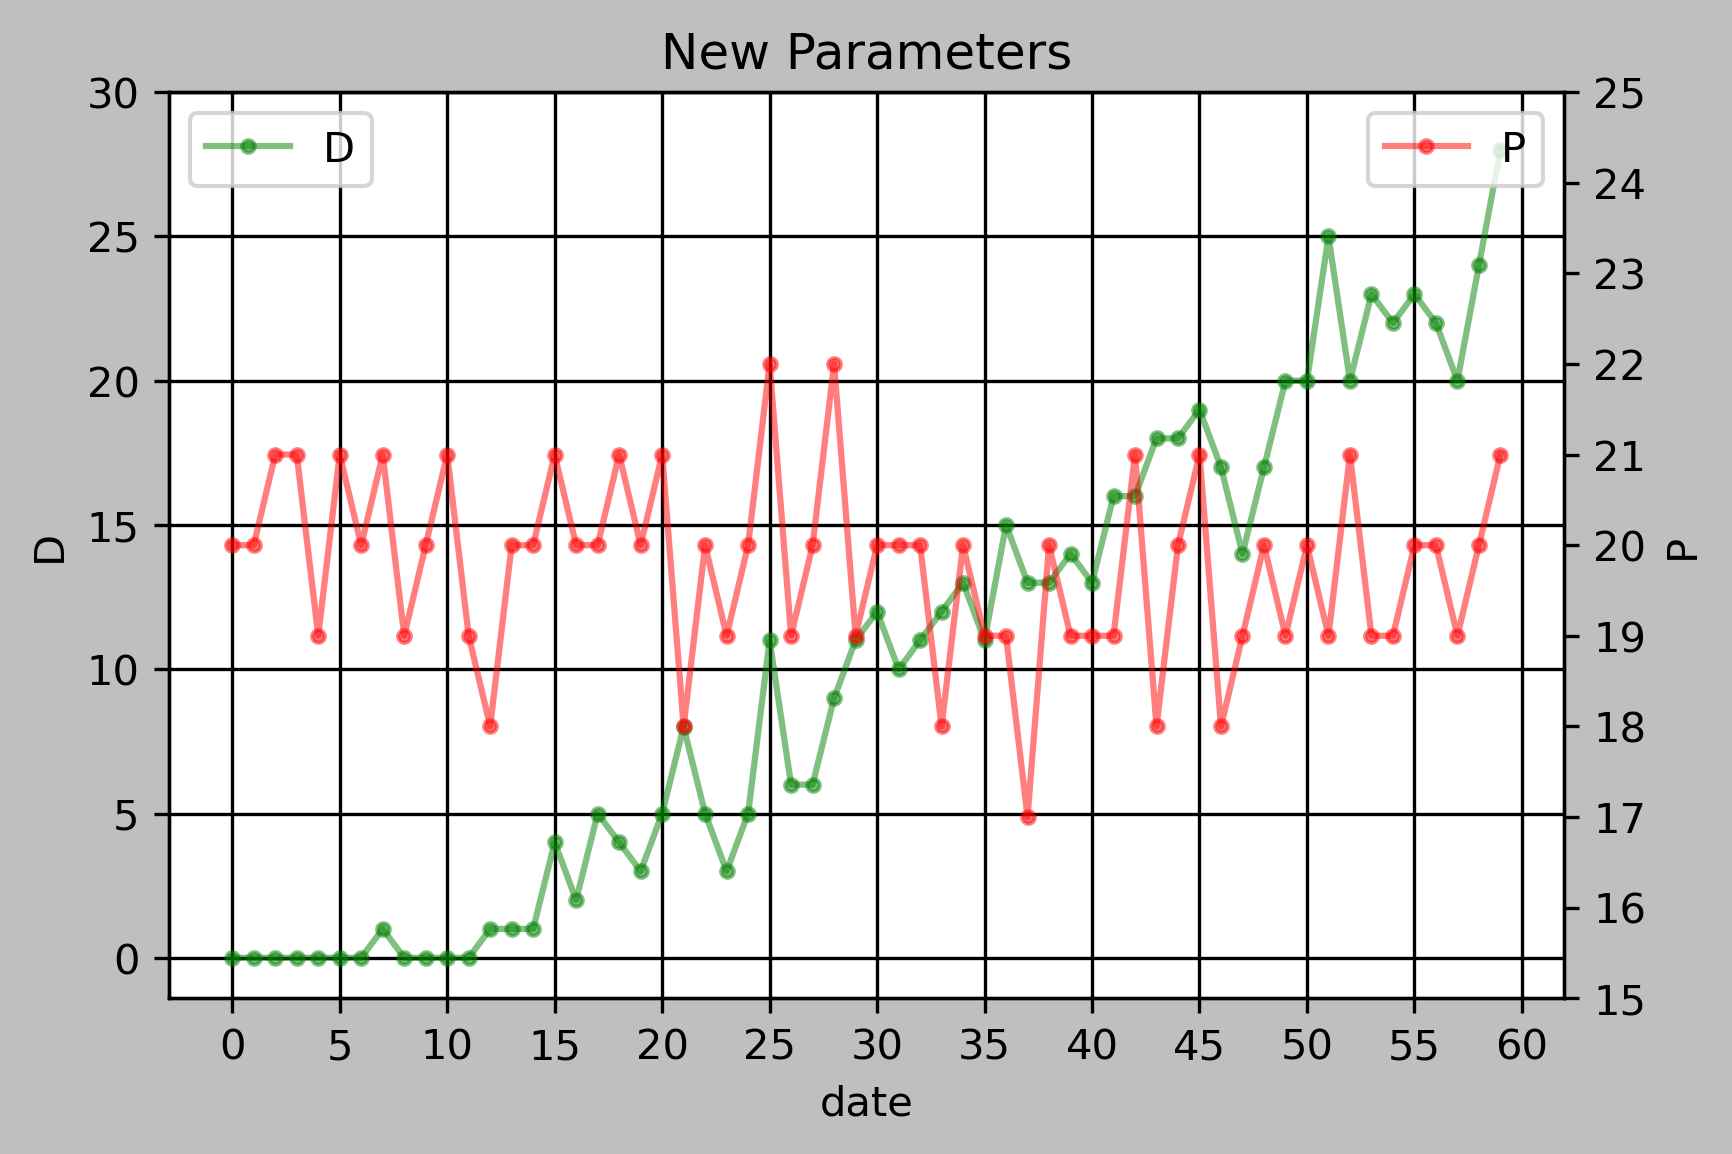


EOQ: cost = 43241.0, 计算耗时 0.019945 seconds.


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [17]:
#-----------------------------------------------------------------------------------------------#
# 四种策略对比：哪种效果最好？
#-----------------------------------------------------------------------------------------------#

days = 60
quantity = 600

# 随机生成五次 P 和 D 的分布（进行五次比赛）
for i in range(5):
    #
    P_list, D_list = generate_PD(days=days)
    #
    start_time = datetime.now()
    EOQ_cost = inventory_cost_df(days, P_list, D_list, Q_list_EOQ)['累计总成本'].iloc[days-1]
    end_time = datetime.now()
    ms = (end_time - start_time).microseconds
    sec = (end_time - start_time).seconds
    delta_time = sec + ms / 1000000
    print(f'\nEOQ: cost = {EOQ_cost}, 计算耗时 {delta_time} seconds.')
    #
    start_time = datetime.now()
    solution1_cost = our_solution1(days, P_list, D_list)['累计总成本'].iloc[days-1]
    end_time = datetime.now()
    ms = (end_time - start_time).microseconds
    sec = (end_time - start_time).seconds
    delta_time = sec + ms / 1000000
    print(f'solution1: cost = {solution1_cost}, 计算耗时 {delta_time} seconds.')
    #
    start_time = datetime.now()
    solution2_cost = our_solution2(days, P_list, D_list)['累计总成本'].iloc[days-1]
    end_time = datetime.now()
    ms = (end_time - start_time).microseconds
    sec = (end_time - start_time).seconds
    delta_time = sec + ms / 1000000
    print(f'solution2: cost = {solution2_cost}, 计算耗时 {delta_time} seconds.')
    #
    start_time = datetime.now()
    solution3_cost = our_solution3(days, P_list, D_list)['累计总成本'].iloc[days-1]
    end_time = datetime.now()
    ms = (end_time - start_time).microseconds
    sec = (end_time - start_time).seconds
    delta_time = sec + ms / 1000000
    print(f'solution3: cost = {solution3_cost}, 计算耗时 {delta_time} seconds.')

